In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
'''
NER.py
AIT 726 Assignment 3: Named Entity Recognition
Haritha G, Giridhar K
Spring 2020
Instructions for execution
Pseudocode
1. Read data
    CONLL201
    3
    945 sentences
    204566 words
    O         38322
    B-LOC      1668
    B-ORG      1661
    B-PER      1617
    I-PER      1156
    I-ORG       835
    B-MISC      702
    I-LOC       257
    I-MISC      216
    ignore chunk and POS information
2. Formatting
    Stop words are not removed
    No Stemming
    No Lemmatization
    Tokenization is already done
    padding 0s and tag is  <pad>
    (every sentence will have the same length)
3. Vector Representations
    pretrained word embeddings given (word2vec) 300 dim x 3M words
    lookup the representation for every word in the dataset's vocabulary
    ------dimensions--------
    input: |V| x 300
    H: 256
    Output: 10
4. Classification architechtures  for Training
    RNN, LSTM and GRU
        one layer 256 hidden units
        Fully connected output layer
        Adam optimizer
        cross-entropy loss
        learning rate alpha= 0.0001
        minibatch size = 2000 
        200 epochs
    Bidirectional RNN, LSTM, GRU
        2 layers 256 hidden units each
        Fully connected output layer
        Adam optimizer
        cross-entropy 
        alpha 0.0001
        minibatch size= 2000
        200 epochs
5. Performance Evaluation on 20 epochs
    Validation                  accuracy
    RNN
    LSTM
    GRU
    Bidirectional RNN
    Bidirectional LSTM
    Bidirectional GRU
    
6. Statistical test to check whether one model is better than the other
    Test Accuracy 
    
    Confusion Matrix
    
    References:
    https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
    https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
    https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
    https://blog.floydhub.com/gru-with-pytorch/
    #https://medium.com/p/717b88a128c0/responses/show
    
    '''

"\nNER.py\nAIT 726 Assignment 3: Named Entity Recognition\nHaritha G, Giridhar K\nSpring 2020\nInstructions for execution\nPseudocode\n1. Read data\n    CONLL201\n    3\n    945 sentences\n    204566 words\n    O         38322\n    B-LOC      1668\n    B-ORG      1661\n    B-PER      1617\n    I-PER      1156\n    I-ORG       835\n    B-MISC      702\n    I-LOC       257\n    I-MISC      216\n    ignore chunk and POS information\n2. Formatting\n    Stop words are not removed\n    No Stemming\n    No Lemmatization\n    Tokenization is already done\n    padding 0s and tag is  <pad>\n    (every sentence will have the same length)\n3. Vector Representations\n    pretrained word embeddings given (word2vec) 300 dim x 3M words\n    lookup the representation for every word in the dataset's vocabulary\n    ------dimensions--------\n    input: |V| x 300\n    H: 256\n    Output: 10\n4. Classification architechtures  for Training\n    RNN, LSTM and GRU\n        one layer 256 hidden units\n        

Load packages

In [0]:
import os
import sys
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import operator
import random

from collections import defaultdict
from pathlib import Path

import nltk as nl
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from gensim import models

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

stdoutorigin = sys.stdout
sys.stdout = open("Statuslog.txt", "w")

'''
This method does the following:
    1. Lower case capitalized words
        words that start with a capital letter, but not all capital words such as USA.
    2. padding 0s and tag is  <pad> 
        Identify the sentence with max length
        Append 0s at the end of shorter sentences to make them match this max length
        Set the tag for the 0s to <pad>
'''
def preprocess(df):
    def tolower(text):
        lowerlist=[]
        for word in text:
            pattern = re.compile('[A-Z][a-z]+')
            if re.match(pattern,word):
                cleantext1 = re.sub(pattern, word.lower(), word)
                lowerlist.append(cleantext1)
            else:
                lowerlist.append(word)
        return lowerlist
    def getMaxlength(words):
        sentlist = []
        sentence = []
        for word in words:
            if(word == '-DOCSTART-'):
                sentlist.append(sentence)
                sentence = []
                continue
            else:
                sentence.append(word) 
        maxlen = max(len(x) for x in sentlist )
        print('maximum length of sentence in the data is ', maxlen)
        #print('sent with max length is -> ', max((x) for x in sentlist) )
        print('Number of sentences are ', len(sentlist))
        return maxlen, len(sentlist)
    
    df['word'] = tolower(df['word'])
    maxsentlen, NoOfSents = getMaxlength(df['word'])
    start = 0
    index = 0
    newwords = []
    newpostag = []
    newchunktag = []
    newnertag = []
    for index in range(0, len(df)):
        if(df.iloc[index]['word'] != '-DOCSTART-'):
            newwords.append(df.iloc[index]['word'])
            newpostag.append(df.iloc[index]['pos'])
            newchunktag.append(df.iloc[index]['chunk'])
            newnertag.append(df.iloc[index]['ner'])
            #index += 1
            start += 1
        else:
            for i in range(start, maxsentlen):
                newwords.append(0)
                newpostag.append(0)
                newchunktag.append(0)
                newnertag.append('<pad>')
            start = 0
    
    newdf = pd.DataFrame(list(zip(newwords, newpostag, newchunktag, newnertag)),  columns =['word', 'pos', 'chunk', 'ner'])
    return newdf

'''
This method takes care of reading double quotes and NAs from the input text file for data  
'''
def cleaning(path, filename):
    fin = open(path + filename, "rt")
    fout = open(path + 'newdata/'+ filename, "w+")

    for line in fin:
        line = line.replace('"', '/"')
        fout.write(line.replace('NA', 'None'))
    
    fin.close()
    fout.close()

### The below are the classes for RNN, LSTM and GRU classifiers
The classes contain initializer and forward methods
#### Arguments for init
        batch_size : Fixed Size of the batch 2000
        output_size : 10 (the class levels for NER)
        hidden_size : 256 
        vocab_size : Size of the vocabulary from train data
        embedding_length : Embeddding dimension of Google news 300
        word_embeddings : Pre-trained embedding vectors of google news from which the lookup table is created
        bidirectional : Flag that indicates if the model should be bidirectional or not
init_hidden is done based on the the bidirectional flag.

In [0]:
#RNN Class
class RNN(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings, bidirectional, requires_grad=False):
        super(RNN, self).__init__()

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.bidirectional = bidirectional
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
        self.rnn = nn.RNN(embedding_length, hidden_size, num_layers=1, bidirectional=bidirectional)
        if(self.bidirectional == True):
            self.label = nn.Linear(2*hidden_size, output_size)
        else:
            self.label = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax()
    
    def init_hidden(self, biflag, batch_size):
        return Variable(torch.zeros(biflag, batch_size, self.hidden_size)).to(device)
        
    def forward(self, input_sentences, batch_size=None):        
        input = self.word_embeddings(input_sentences)
        input = input.permute(1, 0, 2)
        
        if(self.bidirectional == True):
            self.hidden = self.init_hidden(2, batch_size)
        else:
            self.hidden = self.init_hidden(1, batch_size)
       
        output, h_n = self.rnn(input, self.hidden)
        # h_n.size() = (4, batch_size, hidden_size)
        h_n = h_n.permute(1, 0, 2) # h_n.size() = (batch_size, 4, hidden_size)
        h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
        # h_n.size() = (batch_size, 4*hidden_size)
        
        logits = self.softmax(self.label(h_n)) # size is (batch_size, output_size)        
        return logits

#LSTM Class
class LSTMClassifier(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings, bidirectional, requires_grad=False):
        super(LSTMClassifier, self).__init__()       
        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        
        self.bidirectional = bidirectional
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
        self.word_embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
        self.lstm = nn.LSTM(embedding_length, hidden_size, bidirectional=bidirectional)
        self.label = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax()
        
    def init_hidden(self, biflag, batch_size):
        return(Variable(torch.randn(biflag, batch_size, self.hidden_size)).to(device),
                        Variable(torch.randn(biflag, batch_size, self.hidden_size)).to(device))

    def forward(self, input_sentence, batch_size):
        input = self.word_embeddings(input_sentence) 
        input = input.permute(1, 0, 2)
        if(self.bidirectional == True):
            self.hidden = self.init_hidden(2, batch_size)
        else:
            self.hidden = self.init_hidden(1, batch_size)       
        output, (final_hidden_state, final_cell_state) = self.lstm(input, self.hidden)
        final_output = self.softmax(self.label(final_hidden_state[-1])) 
        
        return final_output

#GRU Class
class GRUNet(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings, bidirectional, requires_grad=False):
        super(GRUNet, self).__init__()
        
        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        
        self.bidirectional = bidirectional
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
        self.word_embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
        self.gru = nn.GRU(embedding_length, hidden_size, bidirectional=bidirectional)
        if(self.bidirectional == True):
            self.label = nn.Linear(2*hidden_size, output_size)
        else:
            self.label = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax()
        
    def init_hidden(self,  biflag, batch_size):
        return Variable(torch.zeros(biflag, batch_size, self.hidden_size)).to(device)
               
    def forward(self, input_sentence, batch_size=None):
        input = self.word_embeddings(input_sentence) # orginal input dimensions are (batch_size, num_sequences,  embedding_length)
        input = input.permute(1, 0, 2) # This is required because the dimesions expected by lstm is (num_sequences, batch_size, embedding_length)
        if(self.bidirectional == True):
            self.hidden = self.init_hidden(2, batch_size)
        else:
            self.hidden = self.init_hidden(1, batch_size)
        output, h = self.gru(input, self.hidden)
        final_out = self.softmax(self.label(output[-1]))
        return final_out

### This method trains on the given data for below parameters and validates. 
##### epochs : variable
##### batch_size : 2000
##### loss : cross_entropy
##### optimizer : Adam
##### Inputs : model, train_X, train_y, val_X, val_y, lr, epochs=2, batch_size=2000
##### outputs : minimum validation loss, maximum validation accuracy

In [0]:
def Training(model, train_X, train_y, val_X, val_y, lr, epochs=2, batch_size=2000):
    if(val_X != None):
      valid_preds = np.zeros((val_X.size(0)))
    trainloss = []
    testloss = []
    testaccuracy = []
    model.to(device)
    print('started training- running for {} epochs'.format(epochs))
    for e in range(epochs):
        start_time = time.time()
        optimizer = optim.Adam(model.parameters(), lr=lr)  #Optimizing with Stochastic Gradient Descent
        loss_fn = F.cross_entropy
        
        #Convert to tensor data
        train_tsdata = torch.utils.data.TensorDataset(train_X, train_y)
        if(val_X != None):
          valid_tsdata = torch.utils.data.TensorDataset(val_X, val_y)
        #Feed the tensor data to data loader. This partitions the data based on batch size
        train_loader = torch.utils.data.DataLoader(train_tsdata, batch_size=batch_size, shuffle=True)
        if(val_X != None):
          valid_loader = torch.utils.data.DataLoader(valid_tsdata, batch_size=batch_size, shuffle=False)
        if(train_loader == None):
            print('null object')
        #Run the model on train set and capture loss
        else:
            model.train()
            avg_loss = 0.
            #counter = 0
            for x_batch, y_batch in train_loader:
                X = Variable(torch.LongTensor(x_batch)).to(device)
                y = Variable(torch.LongTensor(y_batch.long())).to(device)
                optimizer.zero_grad() #null the gradients
                y_pred = model(X, X.shape[0]) #forward pass                
                loss = loss_fn(y_pred.squeeze(), y.squeeze()) #Compute loss                
                loss.backward() #back propagate
                optimizer.step()
                avg_loss += loss.item() / len(train_loader)
            trainloss.append(avg_loss)
            
            if(val_X != None):
              #Run the model on validation set and capture loss
              model.eval()
              avg_val_loss = 0.
              testacc = 0
              for i, (x_batch, y_batch) in enumerate(valid_loader):
                  X_val = Variable(torch.LongTensor(x_batch)).to(device)
                  y_val = Variable(torch.LongTensor(y_batch.long())).to(device)
                  y_pred_val = model(X_val, X_val.shape[0])
                  avg_val_loss += loss_fn(y_pred_val.squeeze(), y_val.squeeze()).item() / len(valid_loader)
                  #valid_preds[i * batch_size:(i+1) * batch_size] = y_pred_val[:, 0].data.to(device)
                  #p =torch.argmax().data.cpu().numpy()   
                  p = y_pred_val.argmax(dim=1).cpu().numpy() #Predictions               
                  r = y_batch.float()[:, 0].data.cpu().numpy() #Truth
                  testacc += np.sum(p == r)                
              elapsed_time = time.time() - start_time
      
              if (e % 10 == 9):
                print('\t Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(e + 1, epochs, avg_loss, avg_val_loss, elapsed_time))
              testloss.append(avg_val_loss)
              testaccuracy.append(testacc/ len(val_y))

    if(len(testloss) > 0):  
      #Visualize the trainloss, validation loss and validation accuracy
      plt.title("plot of train,val loss and val accuracy for lr = {}".format(lr))
      plt.plot(trainloss)
      plt.plot(testloss)
      plt.show()
      plt.title("plot of val accuracy for lr = {}".format(lr))
      plt.plot(testaccuracy)
      plt.show()
    return testloss, testaccuracy

This method is used for testing and returning the final predictions.

Inputs are testX, test label, and the model that is loaded from the saved artefacts


In [0]:
def Testing(test_X, test_y, model):
  predictions = [] #np.zeros((test_X.size(0)))
  test_tsdata = torch.utils.data.TensorDataset(test_X, test_y)
  test_loader = torch.utils.data.DataLoader(test_tsdata, batch_size=1, shuffle=False)
  for i, (x_batch, y_batch) in enumerate(test_loader):
    X_test = Variable(torch.LongTensor(x_batch)).to(device)
    y_test = Variable(torch.LongTensor(y_batch.long())).to(device)
    y_pred_test = model(X_test, X_test.shape[0])
    predictions.append(np.argmax(y_pred_test.data.cpu().numpy()))
  return predictions

### preprocessing and preparing data

In [0]:
traindata= pd.read_csv("train.txt", sep= ' ')
validata= pd.read_csv("valid.txt", sep= ' ')
testdata= pd.read_csv("test.txt", sep= ' ')

print(traindata.head(10))
print(traindata.columns)

print(traindata.shape)
traindata.columns = ['word', 'pos', 'chunk', 'ner']
validata.columns = ['word', 'pos', 'chunk', 'ner']

newdf = preprocess(traindata)
print('preprocess train done')
newdf_val = preprocess(validata)
print('preprocess validation done')


In [0]:
testdata.columns = ['word', 'pos', 'chunk', 'ner']
newdf_test = preprocess(testdata)
print('preprocess test done')

In [8]:
#Load Embedding file
google = models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/NLP/GoogleNews-vectors-negative300.bin', binary=True)
print('Loaded Embedding file')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#creating vocabulary
def createvocab(text):
      V=[]
      for word in text:
          if word in V:
              continue
          else :
              V.append(word)
      return V

def createWeightsLookup(text, embedding):
  vocab = createvocab(text)
  print('vocab length is ', len(vocab))
  
  matrix_len = len(vocab)
  weights_matrix = np.zeros((matrix_len, 300))
  words_found = 0

  #Create dictionary of words and representation from google news vector
  for i, word in enumerate(vocab):
      try: 
          word = str(word)
          weights_matrix[i] = embedding[word]
          words_found += 1
      except KeyError:
          weights_matrix[i] = np.zeros((300,))

  print('Created weights matrix from pre trained that would act as a basis for lookup table')
  return vocab, weights_matrix

#This assigns the indices for words given the dataset
def PrepareDataForNeuralNetwork(data, indexvecs):
  #Get words from train data as X and assign indices 
  X = data.word.copy()
  #Subset to not include 0's because this lookup is taking time
  words = X[X != 0]
  indices = words.index
  #Lookup the indices of the words in training data row by row from indexvecs created above
  for i, word in zip(indices, words):
    X[i] = indexvecs[word] if word in indexvecs else 0 
  #For zeros assign it seperately
  zeroindex = data[data.word == 0].index
  X[zeroindex] = indexvecs['0']
  return X

In [0]:
#Gather the indixes for words from vocabulary
vocab, weights_matrix = createWeightsLookup(newdf.word, google)
wordindexlookup = {wx: vocab.index(wx) for wx in vocab}
train_X = PrepareDataForNeuralNetwork(newdf, wordindexlookup)
val_X = PrepareDataForNeuralNetwork(newdf_val, wordindexlookup)
test_X = PrepareDataForNeuralNetwork(newdf_test, wordindexlookup)

#Label encode the output feature
le = preprocessing.LabelEncoder()
ytrain = le.fit_transform(newdf.ner.values)
yval = le.transform(newdf_val.ner.values)
ytest = le.transform(newdf_test.ner.values)

In [0]:
print(len(train_X))
print(len(newdf))
print(len(val_X))
print(len(newdf_val))
print(len(test_X))
print(len(newdf_test))

### Data preparation for training

In [0]:
#Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Convert train data to tensors
train_Xf= np.array(train_X.values.astype(int).reshape((newdf.shape[0],-1)))
trainX = torch.from_numpy(train_Xf).long()
trainy = torch.from_numpy(ytrain.reshape((newdf.shape[0],-1))).long()
#Convert validation data to tensors
val_Xf= np.array(val_X.values.astype(int).reshape((newdf_val.shape[0],-1)))
valX = torch.from_numpy(val_Xf).long()
valy = torch.from_numpy(yval.reshape((newdf_val.shape[0],-1))).long()
print(trainX.shape)
print(trainy.shape)
print(valX.shape)
print(valy.shape)
#Convert test data to tensors
test_Xf= np.array(test_X.values.astype(int).reshape((newdf_test.shape[0],-1)))
testX = torch.from_numpy(test_Xf).long()
testy = torch.from_numpy(ytest.reshape((newdf_test.shape[0],-1))).long()
print(testX.shape)
print(testy.shape)
print('Data ready for training')

### Model Building

In [0]:
#Set the parameters
learningrate = 0.001
runs = 50
models = ['rnn', 'birnn', 'lstm', 'bilstm', 'gru', 'bigru']
modelacc = {el:0 for el in models}

RNN:
training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


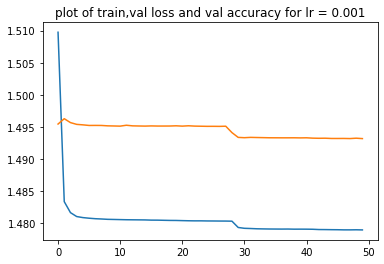

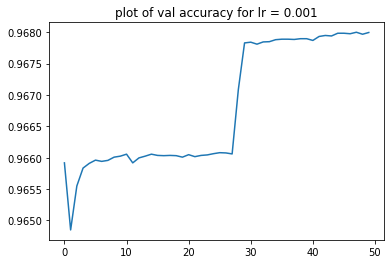

In [0]:
print("****************** RNN ******************")
print("Training.....")

wm = torch.from_numpy(weights_matrix).float()
model_rnn = RNN(batch_size= 2000, output_size= len(newdf.ner.unique()), hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = False)
loss_r, acc_r = Training(model_rnn, trainX, trainy, valX, valy, lr= learningrate, epochs=runs, batch_size=2000)
path = '/content/drive/My Drive/ModelArtefacts/RNN/rnn.pt'
torch.save(model_rnn.state_dict(), path)
modelacc['rnn'] = max(acc_r)

In [0]:
print('Minimum Validation loss is ', np.round(min(loss_r), 2) )
print('Maximum Validation accuracy is ', np.round(max(acc_r), 2))

In [0]:
#Testing
print("Testing.....")
model_rnn.load_state_dict(torch.load(path))
preds_v_r = Testing(valX, valy, model_rnn)
preds_r = Testing(testX, testy, model_rnn)
print("Done")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:

file1 = open("/content/drive/My Drive/ModelArtefacts/rnn.txt","w") 
file1.writelines(str(preds_v_r))
file1.close()
file1 = open("/content/drive/My Drive/ModelArtefacts/rnn_test.txt","w") 
file1.writelines(str(preds_r))
file1.close()

In [0]:
# #Script to read the above text file and get predictions
# file = open("rnn - Copy.txt","r+") 
# v = file.read()
# len(list(map(int, v[1:-1].split(', '))))
# file.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


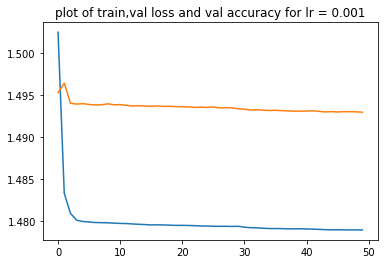

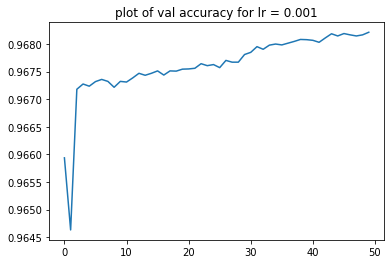

In [0]:
#Bidirectional-RNN
print("****************** Bidirectional - RNN ******************")
print("Training.....")
wm = torch.from_numpy(weights_matrix).float()
model_bi_rnn = RNN(batch_size= 2000, output_size= len(newdf.ner.unique()), hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = True)
loss_bi_r, acc_bi_r = Training(model_bi_rnn, trainX, trainy, valX, valy, lr= learningrate, epochs=runs, batch_size=2000)
path = '/content/drive/My Drive/ModelArtefacts/BIRNN/birnn.pt'
torch.save(model_bi_rnn.state_dict(), path)
modelacc['birnn'] = max(acc_bi_r)

In [0]:
print('Minimum Validation loss is ', np.round(min(loss_bi_r), 2) )
print('Maximum Validation accuracy is ', np.round(max(acc_bi_r), 2))

In [0]:
#Testing
print("Testing.....")
model_bi_rnn.load_state_dict(torch.load(path))
preds_bi_v_r = Testing(valX, valy, model_bi_rnn)
preds_bi_r = Testing(testX, testy, model_bi_rnn)
print("Done")

file1 = open("/content/drive/My Drive/ModelArtefacts/birnn.txt","w") 
file1.writelines(str(preds_bi_v_r)) 
file1.close()
file1 = open("/content/drive/My Drive/ModelArtefacts/birnntest.txt","w")
file1.writelines(str(preds_bi_r)) 
file1.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


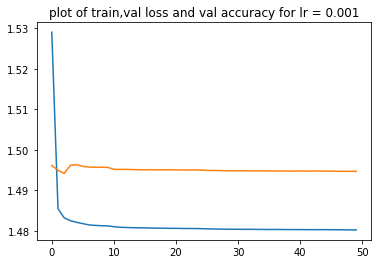

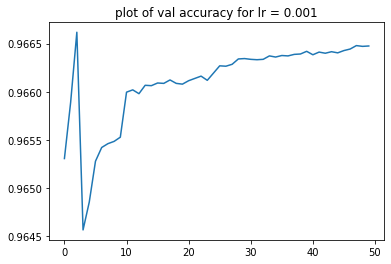

In [0]:
#LSTM
#Training
print("****************** LSTM ******************")
print("Training.....")
wm = torch.from_numpy(weights_matrix).float()
model_lstm = LSTMClassifier(batch_size= 2000, output_size= len(newdf.ner.unique()), hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = False)
loss_l, acc_l = Training(model_lstm, trainX, trainy, valX, valy, lr= learningrate, epochs=runs, batch_size=2000)
path = '/content/drive/My Drive/ModelArtefacts/LSTM/lstm.pt'
torch.save(model_lstm.state_dict(), path)
modelacc['lstm'] = max(acc_l)

In [0]:
print('Minimum Validation loss is ', np.round(min(loss_l), 2) )
print('Maximum Validation accuracy is ', np.round(max(acc_l), 2))

In [0]:
#Testing
print("Testing.....")
model_lstm.load_state_dict(torch.load(path))
preds_v_l = Testing(valX, valy, model_lstm)
preds_l = Testing(testX, testy, model_lstm)
print("Done")

file1 = open("/content/drive/My Drive/ModelArtefacts/lstm.txt","w") 
file1.writelines(str(preds_v_l)) 
file1.close()
file1 = open("/content/drive/My Drive/ModelArtefacts/lstmtest.txt","w") 
file1.writelines(str(preds_l)) 
file1.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


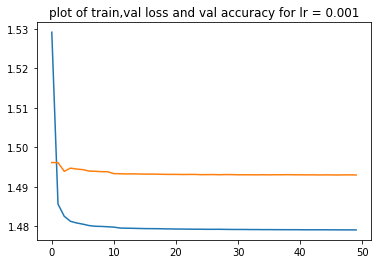

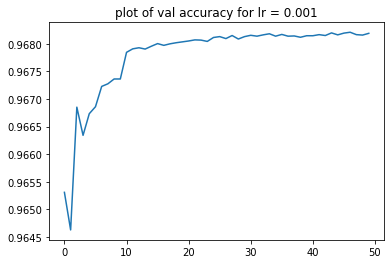

In [0]:
#bidirectional LSTM
#Training
print("****************** Bidirectional - LSTM ******************")
print("Training.....")
wm = torch.from_numpy(weights_matrix).float()
start_time = time.time()
model_bi_lstm = LSTMClassifier(batch_size= 2000, output_size= len(newdf.ner.unique()), hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = True)
loss_bi_l, acc_bi_l = Training(model_bi_lstm, trainX, trainy, valX, valy, lr= learningrate, epochs=runs, batch_size=2000)
elapsed_time = time.time() - start_time
print('total time taken ', elapsed_time)
modelacc['bilstm'] = max(acc_bi_l)

In [0]:
print('Minimum Validation loss is ', np.round(min(loss_bi_l), 2) )
print('Maximum Validation accuracy is ', np.round(max(acc_bi_l), 2))

In [0]:
path = '/content/drive/My Drive/ModelArtefacts/BILSTM/bilstm.pt'
torch.save(model_bi_lstm.state_dict(), path)

In [0]:
#Testing
print("Testing.....")
model_bi_lstm.load_state_dict(torch.load(path))
preds_bi_v_l = Testing(valX, valy, model_bi_lstm)
preds_bi_l = Testing(testX, testy, model_bi_lstm)
print("Done")

file1 = open("/content/drive/My Drive/ModelArtefacts/bilstm.txt","w") 
file1.writelines(str(preds_bi_v_l)) 
file1.close()
file1 = open("/content/drive/My Drive/ModelArtefacts/bilstmtest.txt","w") 
file1.writelines(str(preds_bi_l)) 
file1.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


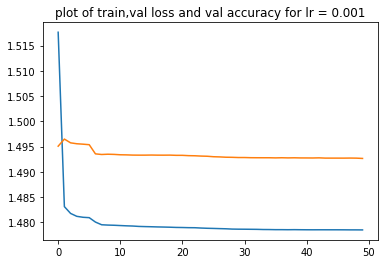

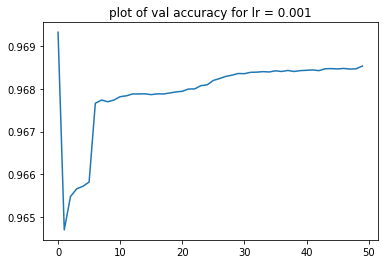

In [0]:
#GRU
# training
print("****************** GRU ******************")
print("Training.....")
wm = torch.from_numpy(weights_matrix).float()
model_gru = GRUNet(batch_size= 2000, output_size= len(newdf.ner.unique()), hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = False)
loss_g, acc_g = Training(model_gru, trainX, trainy, valX, valy, lr= learningrate, epochs=runs, batch_size=2000)
path = '/content/drive/My Drive/ModelArtefacts/GRU/gru.pt'
torch.save(model_gru.state_dict(), path)
modelacc['gru'] = max(acc_g)

In [0]:
print('Minimum Validation loss is ', np.round(min(loss_g), 2) )
print('Maximum Validation accuracy is ', np.round(max(acc_g), 2))

In [0]:
#Testing
print("Testing.....")
model_gru.load_state_dict(torch.load(path))
preds_v_g = Testing(valX, valy, model_gru)
preds_g = Testing(testX, testy, model_gru)
print("Done")

file1 = open("/content/drive/My Drive/ModelArtefacts/gru.txt","w") 
file1.writelines(str(preds_v_g)) 
file1.close()
file1 = open("/content/drive/My Drive/ModelArtefacts/grutest.txt","w") 
file1.writelines(str(preds_g)) 
file1.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


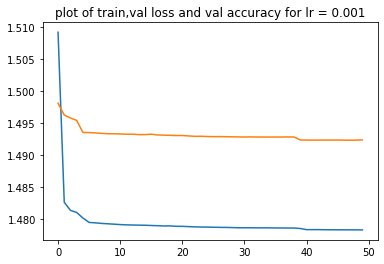

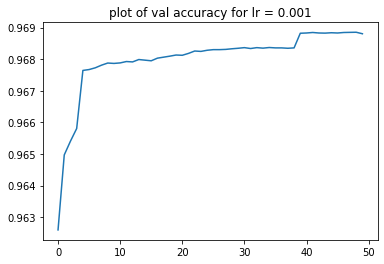

In [0]:
#Bidirectional - GRU
#Training
print("****************** Bidirectional - GRU ******************")
print("Training.....")
wm = torch.from_numpy(weights_matrix).float()
model_bi_gru = GRUNet(batch_size= 2000, output_size= len(newdf.ner.unique()), hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = True)
loss_bi_g, acc_bi_g = Training(model_bi_gru, trainX, trainy, valX, valy, lr= learningrate, epochs=runs, batch_size=2000)
path = '/content/drive/My Drive/ModelArtefacts/BIGRU/bigru.pt'
torch.save(model_bi_gru.state_dict(), path)
modelacc['bigru'] = max(acc_bi_g)

In [0]:
print('Minimum Validation loss is ', np.round(min(loss_bi_g), 2) )
print('Maximum Validation accuracy is ', np.round(max(acc_bi_g), 2))

In [0]:
# Testing
print("Testing.....")
model_bi_gru.load_state_dict(torch.load(path))
preds_bi_v_g = Testing(valX, valy, model_bi_gru)
preds_bi_g = Testing(testX, testy, model_bi_gru)
print("Done")

file1 = open("/content/drive/My Drive/ModelArtefacts/bigru.txt","w") 
file1.writelines(str(preds_bi_v_g)) 
file1.close()
file1 = open("/content/drive/My Drive/ModelArtefacts/bigrutest.txt","w") 
file1.writelines(str(preds_bi_g)) 
file1.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
#This prints the csv file with numerical labels for each model along with truth 
colnames = ['word', 'gold', 'rnn', 'birnn', 'lstm', 'bilstm', 'gru', 'bigru']
models = ['rnn', 'birnn', 'lstm', 'bilstm', 'gru', 'bigru']
reals = valy.numpy().reshape(1,-1)[0].tolist()
list_of_tuples = list(zip(newdf_val.word.values, reals, preds_v_r, preds_bi_v_r, preds_v_l, preds_bi_v_l, preds_v_g, preds_bi_v_g))
predictions_df = pd.DataFrame(list_of_tuples, columns = colnames)

predictions_df.to_csv('/content/drive/My Drive/ModelArtefacts/predictions_encoded.csv')

In [0]:
print(modelacc)

#### Determine the best model



*  Based on accuracy returned for each model



In [0]:
print('Determine model with max accuracy---')
ba = max(modelacc.items(), key=operator.itemgetter(1))
print('model ', ba[0] , ' has the highest accuracy of ', np.round(ba[1], 2))

Account for 'pad' tags

In [0]:
predictions_df = pd.read_csv("predictions.csv")

#Exclude ner labels with <pad>
d = predictions_df[predictions_df['gold'] != 0]
d = d.reset_index(drop = True)
d.shape #(51362, 9)

#collect labels and create value counts dictionary
labelcol = newdf_test[newdf_test['ner'] != '<pad>']['ner']
vc = labelcol.value_counts(normalize=True)

In [0]:
vc

O         0.825304
B-LOC     0.035921
B-ORG     0.035770
B-PER     0.034823
I-PER     0.024895
I-ORG     0.017982
B-MISC    0.015118
I-LOC     0.005535
I-MISC    0.004652
Name: ner, dtype: float64

In [0]:
d.head()

,word,gold,rnn,birnn,lstm,bilstm,gru,bigru
0,CRICKET,9,9,9,9,9,9,9
1,-,9,9,9,9,9,9,9
2,LEICESTERSHIRE,3,3,3,3,3,3,3
3,TAKE,9,9,9,9,9,9,9
4,OVER,9,9,9,9,9,9,9


In [0]:
models

['rnn', 'birnn', 'lstm', 'bilstm', 'gru', 'bigru']

In [0]:
print("************************************************************************************")
print("Use statistical test to determine the best model")

In [0]:
#For each model, change the <pad> tag based on drawing the tags that follow the distribution similar to that of original 
for c in models:
  pad_rows = d[d[c] == 0]
  non_pad_rows = d[d[c] != 0]
  l = len(pad_rows)
  print(l)
  lst = list(labelcol.unique())
  newpad_rows = list(itertools.chain.from_iterable(itertools.repeat(x, int(np.ceil(vc[x]*l))) for x in lst))
  print(len(newpad_rows))
  finals = newpad_rows[:l]  
  pad_rows[c] = le.transform(finals)
  print(d.head())
  print(d.shape)
  d = pd.concat([pad_rows, non_pad_rows])
  print(d.shape, '------------')
d.to_csv('Modified.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co



*   Perform a statistical test



In [0]:
def BOOTSTRAP(set_X, b): #returns p-value(x)
  d_X = np.sum(list(zip(*set_X))[0]) - np.sum(list(zip(*set_X))[1]) # how much better does algorithm A do than B on x
  d_X_1tob = [] 
  for i in range(0, b):
    A1_b, B1_b = (0, 0)
    for j in range(len(set_X)):   # Draw a bootstrap sample x(i) of size n
      set_Xb = random.choice(set_X)  #set_Xb.append(random.choice(AB)) #Select a member of x at random and add it to x(i)
      A1_b += set_Xb[0]
      B1_b += set_Xb[1]
    d_X_1tob.append(A1_b - B1_b)  #Calculate d(x(i)) # how much better does algorithm A do than B on x(i)
  
  #Count the samples on which algorithm A beat expectations
  s = 0  
  for dx in d_X_1tob:
    if dx > (2 * d_X):
      s += 1    
  
  #onesided empirical p-value which is the percentage of samples on which algorithm A beat expectations 
  p_val = s/b      
  return p_val

In [0]:
def create_Input(real, A, B):
  apred = [0] * len(A)
  bpred = [0] * len(B)
  for i, el in enumerate(real):
    if(real[i] == A[i]):
      apred[i] = 1
    if(real[i] == B[i]):
      bpred[i] = 1
  return list(zip(apred, bpred))


In [0]:
combination = list(itertools.combinations(models, 2))
othercomb = []
for c in combination:
  othercomb.append(c[::-1])
combination = combination + othercomb
perfdict = {el:0 for el in combination}

In [0]:
#Testing bootstrap
for col in perfdict:
  print(col[0], col[1])
  perfdict[col] = BOOTSTRAP(create_Input(d.gold, d[col[0]], d[col[1]]), b = 1000)
  

In [0]:
validata.shape

(51577, 4)

In [0]:
perfdict

In [24]:
models

['rnn', 'birnn', 'lstm', 'bilstm', 'gru', 'bigru']

In [0]:
modelscore = {el:0 for el in models} #Dictionary for models and scores returned from bootstrap test
threshold = 0.05
for k, v in perfdict.items():
  if v < 0.05:
    modelscore[k[0]] += 10
best = max(modelscore.items(), key=operator.itemgetter(1))[0]

In [0]:
print('From the statistical test, the best model is ', best)

#### Final Model training


In [0]:
print("*************************************************")
print("Final model training")
print("The training runs by combining train and validation data")
finaltrain = pd.concat([newdf, newdf_val]).reset_index(drop=True)

In [0]:
print("preparing data for final training")
#Gather the indixes for words from vocabulary
vocab, weights_matrix = createWeightsLookup(finaltrain.word, google)
wordindexlookup = {wx: vocab.index(wx) for wx in vocab}
train_X = PrepareDataForNeuralNetwork(finaltrain, wordindexlookup)
test_X = PrepareDataForNeuralNetwork(newdf_test, wordindexlookup)

#Label encode the output feature
le = preprocessing.LabelEncoder()
ytrain = le.fit_transform(finaltrain.ner.values)
ytest = le.transform(newdf_test.ner.values)

In [0]:
#Convert train data to tensors
train_Xf= np.array(train_X.values.astype(int).reshape((finaltrain.shape[0],-1)))
trainX = torch.from_numpy(train_Xf).long()
trainy = torch.from_numpy(ytrain.reshape((finaltrain.shape[0],-1))).long()

#Convert test data to tensors
test_Xf= np.array(test_X.values.astype(int).reshape((newdf_test.shape[0],-1)))
testX = torch.from_numpy(test_Xf).long()
testy = torch.from_numpy(ytest.reshape((newdf_test.shape[0],-1))).long()


In [0]:
print(trainX.shape)
print(trainy.shape)
print(testX.shape)
print(testy.shape)
print('Data ready')

In [0]:
print("Training started...")

In [0]:
best{('bigru', 'bilstm'): 0.0,
 ('bigru', 'birnn'): 0.0,
 ('bigru', 'gru'): 0.0,
 ('bigru', 'lstm'): 0.0,
 ('bigru', 'rnn'): 0.0,
 ('bilstm', 'bigru'): 1.0,
 ('bilstm', 'birnn'): 0.417,
 ('bilstm', 'gru'): 1.0,
 ('bilstm', 'lstm'): 0.0,
 ('bilstm', 'rnn'): 0.003,
 ('birnn', 'bigru'): 1.0,
 ('birnn', 'bilstm'): 0.565,
 ('birnn', 'gru'): 1.0,
 ('birnn', 'lstm'): 0.0,
 ('birnn', 'rnn'): 0.0,
 ('gru', 'bigru'): 1.0,
 ('gru', 'bilstm'): 0.0,
 ('gru', 'birnn'): 0.0,
 ('gru', 'lstm'): 0.0,
 ('gru', 'rnn'): 0.0,
 ('lstm', 'bigru'): 1.0,
 ('lstm', 'bilstm'): 1.0,
 ('lstm', 'birnn'): 1.0,
 ('lstm', 'gru'): 1.0,
 ('lstm', 'rnn'): 1.0,
 ('rnn', 'bigru'): 1.0,
 ('rnn', 'bilstm'): 0.999,
 ('rnn', 'birnn'): 0.999,
 ('rnn', 'gru'): 1.0,
 ('rnn', 'lstm'): 0.0}

In [0]:
best = 'bigru'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
wm = torch.from_numpy(weights_matrix).float()
if best == 'rnn':
  model_7 = RNN(batch_size= 2000, output_size= 10, hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = False, requires_grad=True)
elif best == 'birnn':
  model_7 = RNN(batch_size= 2000, output_size= 10, hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = True, requires_grad=True)
elif best == 'lstm':
  model_7 = LSTMClassifier(batch_size= 2000, output_size= 10, hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = False, requires_grad=True)
elif best == 'bilstm':
  model_7 = LSTMClassifier(batch_size= 2000, output_size= 10, hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = True, requires_grad=True)
elif best == 'gru':
  model_7 = GRUNet(batch_size= 2000, output_size= 10, hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = False, requires_grad=True)
elif best == 'bigru':
  model_7 = GRUNet(batch_size= 2000, output_size= 10, hidden_size = 256, vocab_size = len(vocab), embedding_length = 300, word_embeddings= wm, bidirectional = True, requires_grad=True)


In [35]:
device

device(type='cuda')

In [36]:
model_7

GRUNet(
  (word_embeddings): Embedding(25257, 300)
  (gru): GRU(300, 256, bidirectional=True)
  (label): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)

In [39]:

loss, acc = Training(model_7, trainX, trainy, None, None, lr= learningrate, epochs=100, batch_size=2000)
path = '/content/drive/My Drive/ModelArtefacts/model7.pt'
torch.save(model_7.state_dict(), path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [40]:
# Testing
print("Testing.....")
model_7.load_state_dict(torch.load(path))
predictions = Testing(testX, testy, model_7)
print("Done")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
file1 = open("/content/drive/My Drive/ModelArtefacts/model7preds.txt","w") 
file1.writelines(str(predictions)) 
file1.close()

In [0]:
print('Final accuracy is ', np.round(accuracy_score(predictions, testy.numpy().reshape(1,-1)[0].tolist()),2))
print('Final f1 score is ', np.round(f1_score(predictions, testy.numpy().reshape(1,-1)[0].tolist(), average='macro'),2))

In [45]:
len(predictions)

183580

In [0]:
list_of_tuples = list(zip(newdf_test.word.values, le.inverse_transform(testy.numpy().reshape(1,-1)[0].tolist()), le.inverse_transform(predictions)))
predictionslabels_df = pd.DataFrame(list_of_tuples, columns = ['word','truth','preds'])

In [82]:
#Remove pad tags
d = predictionslabels_df[predictionslabels_df['truth'] != '<pad>']
d.shape

(46435, 3)

In [83]:
d.head()

,word,truth,preds
0,SOCCER,O,O
1,-,O,O
2,JAPAN,B-LOC,B-LOC
3,GET,O,B-ORG
4,LUCKY,O,B-ORG


In [0]:
labelcol = newdf_test[newdf_test['ner'] != '<pad>']['ner']
vc = labelcol.value_counts(normalize=True)
#For each model, change the <pad> tag based on drawing the tags that follow the distribution similar to that of original 
c = 'preds'
pad_rows = d[d[c] == '<pad>']
l = len(pad_rows)
lst = list(labelcol.unique())
newpad_rows = list(itertools.chain.from_iterable(itertools.repeat(x, int(np.ceil(vc[x]*l))) for x in lst))
newpad_rows
finals = newpad_rows[:l]  
len(finals)
d.loc[pad_rows.index, c] = finals

In [0]:
d.to_csv(r'Finaltestpreds.txt', header=None, index=None, sep=' ', mode='a')

In [0]:
# #This prints the csv file with accuracies from each model 
# colnames = ['rnn', 'birnn', 'lstm', 'bilstm', 'gru', 'bigru']
# list_of_tuples = list(zip(acc_r, acc_bi_r, acc_l, acc_bi_l, preds_v_r, acc_g, acc_bi_g))
# predictions_df = pd.DataFrame(list_of_tuples, columns = colnames)

# predictions_df.to_csv('predictions_encoded.csv')
# #Convert back the encoded labels to original tags
# real = le.inverse_transform(testy)
# pred_r = le.inverse_transform(preds_v_r)
# pred_bi_r = le.inverse_transform(preds_bi_v_r)
# pred_l = le.inverse_transform(preds_v_l)
# pred_bi_l = le.inverse_transform(preds_bi_v_l)
# pred_g = le.inverse_transform(preds_v_g)
# pred_bi_g = le.inverse_transform(preds_bi_v_g)

# list_of_tuples = list(zip(newdf_test.word.values, real, pred_r, pred_bi_r, pred_l, pred_bi_l, pred_g, pred_bi_g))
# predictionslabels_df = pd.DataFrame(list_of_tuples, columns = colnames)
# predictionslabels_df.to_csv(r'gru.txt', header=None, index=None, sep=' ', mode='a')